alpha = 0.007297352566417119
A_you   = 101(φ^{π-2}-√3) = 0.00730202380709878207853271496266790430491244395103169255976128
  abs err = 0.00000467124068166307853271496266790430491244395103169255976128203,   rel err = 0.00064012813402499222559539299306978012093594073133452068147868
A_other = (φ^π-2-√3)/110 = 0.00729733048714819995876492866682653815314511614169774558789716
  abs err = 0.0000000220792689190412350713331734618468548838583022544121028438199,   rel err = 0.00000302565467655371840208600974915361388108393829603384570602595


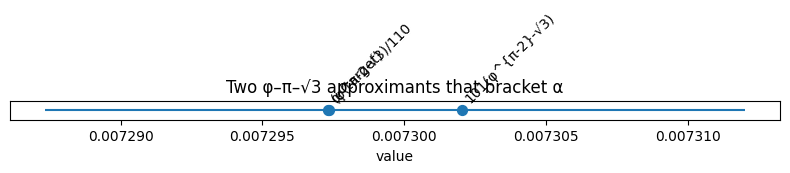

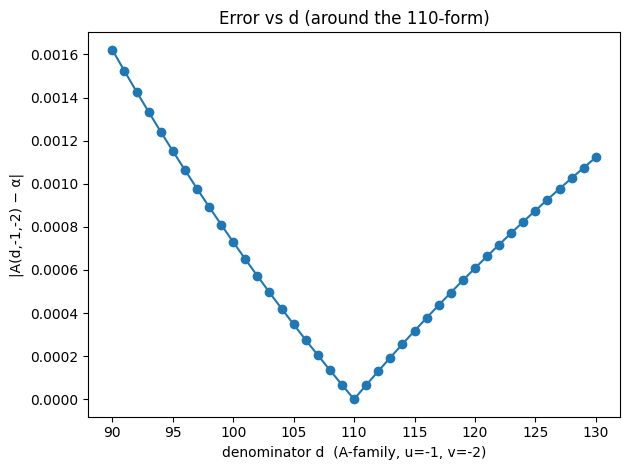

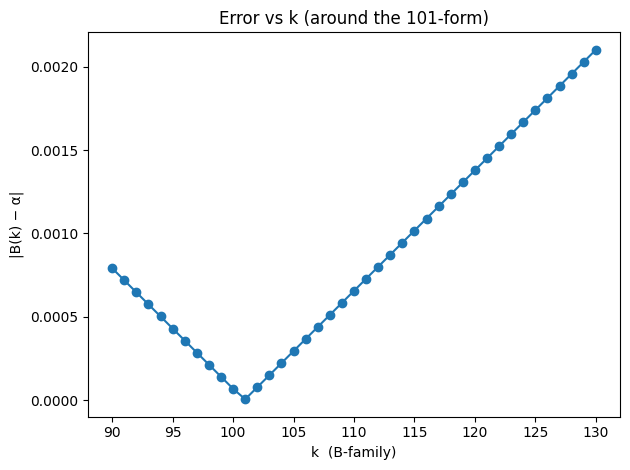

Top A(d,-1,-2): [(2.2079268919041235e-08, 110, 0.0072973304871482), (6.576379536935328e-05, 111, 0.007231588771047765), (6.692590685170664e-05, 109, 0.007364278473268825), (0.00013033155225370834, 112, 0.007167021014163411), (0.00013511367049308466, 108, 0.007432466236910204)]
Top B(k):       [(4.6712406816630785e-06, 101, 0.007302023807098782), (6.762602473515654e-05, 100, 0.007229726541681963), (7.69685060984827e-05, 102, 0.007374321072515602), (0.00013992329015197617, 99, 0.007157429276265143), (0.00014926577151530232, 103, 0.007446618337932421)]
Baseline error (A 110,-1,-2): 2.2079268919041235e-08
Empirical p (null <= baseline): 0.0


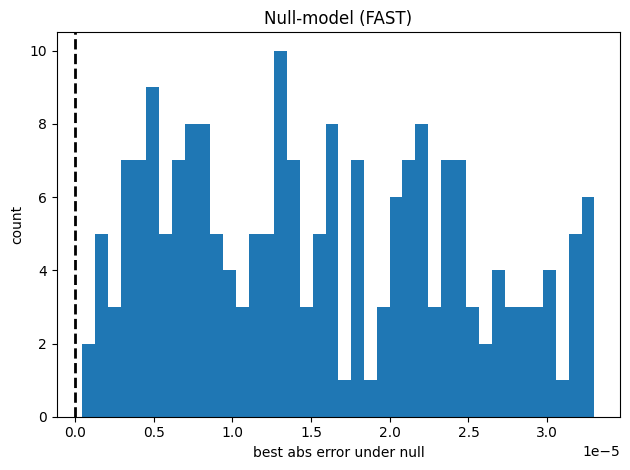

Phi(F_20) = 0.000729736297297362934959757962971593769907485693693161010742188


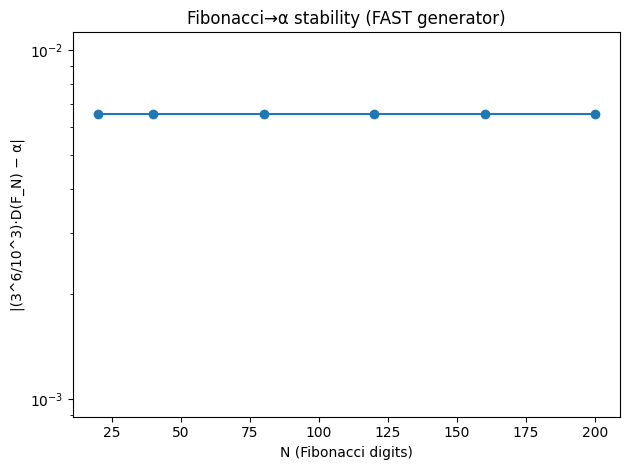

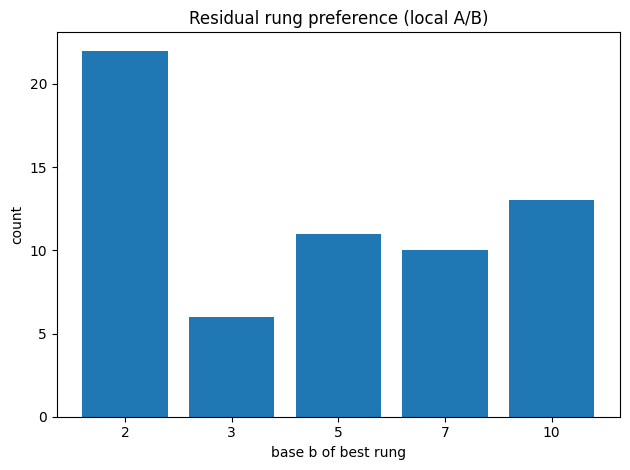

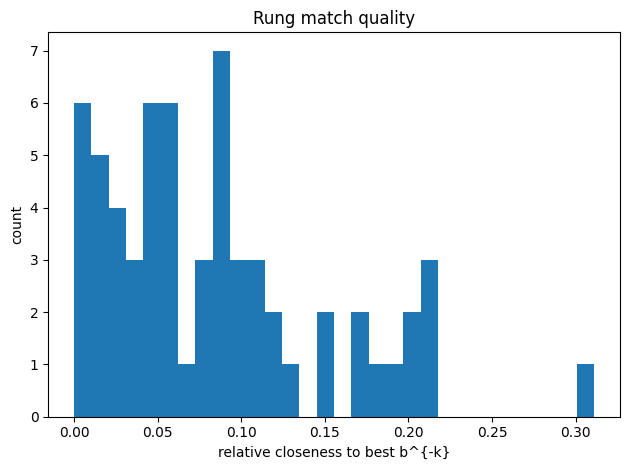

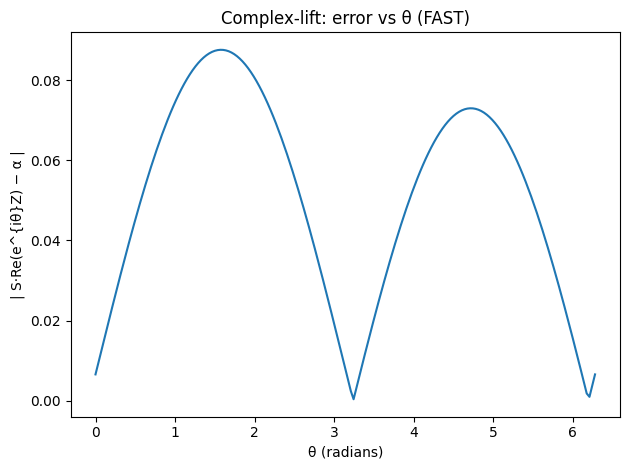


Done. You can re-run with bigger TRIALS or THETAS_N if you want heavier tests.


In [6]:
# === α geometry: one-click Colab cell (FAST) ===
# It computes/plots:
#   1) the two α-approximants (101-form, 110-form) and a bracket plot,
#   2) short grids around each form (error vs parameter),
#   3) a fast, vectorized null-model with empirical p-value,
#   4) Fibonacci→α stability curve,
#   5) residual-rung check (is |x-α|/|α| near b^{-k}?),
#   6) a quick complex-lift rotation experiment.

# ---- speed knobs (safe defaults) ----
FAST_MODE = True          # keep True for quick runs
TRIALS    = 200 if FAST_MODE else 2000      # null-model trials
FIB_NS    = [20, 40, 80, 120, 160, 200]     # Fibonacci lengths
THETAS_N  = 181 if FAST_MODE else 721       # angles for complex-lift

# ---- imports & precision ----
import numpy as np, math, random
import mpmath as mp
import matplotlib.pyplot as plt
mp.mp.dps = 60   # high precision but still fast

# ---- constants ----
alpha = mp.mpf("0.007297352566417119")   # fine-structure constant (CODATA-ish)
phi   = (1 + mp.sqrt(5)) / 2
sqrt3 = mp.sqrt(3)
pi    = mp.pi

print("alpha =", alpha)

# =========================================================
# 1) Two α-approximants and bracket plot
# =========================================================
A_you   = 101*(phi**(pi-2) - sqrt3)           # 101-form
A_other = (phi**pi - 2 - sqrt3) / 110         # 110-form

def report(label, val):
    ae = mp.fabs(val - alpha)
    re = ae/alpha
    print(f"{label:24s} = {val}")
    print(f"  abs err = {ae},   rel err = {re}")

report("A_you   = 101(φ^{π-2}-√3)", A_you)
report("A_other = (φ^π-2-√3)/110", A_other)

# Bracket number-line
xs = [float(A_other), float(alpha), float(A_you)]
labels = ["(φ^π-2-√3)/110", "α (target)", "101(φ^{π-2}-√3)"]
plt.figure(figsize=(8,1.6))
plt.scatter(xs, [0,0,0], s=50)
for x,lab in zip(xs, labels): plt.text(x, 0.03, lab, rotation=45, ha='left', va='bottom')
plt.hlines(0, min(xs)-1e-5, max(xs)+1e-5)
plt.yticks([])
plt.title("Two φ–π–√3 approximants that bracket α")
plt.xlabel("value"); plt.tight_layout(); plt.show()

# =========================================================
# 2) Short grids around each form
# =========================================================
phi_pi = phi**pi
def A_family(d, u=-1, v=-2):   # fixed (u,v) of interest from discussion
    return (phi_pi + u*sqrt3 + v)/d
def B_family(k):
    return k*(phi**(pi-2) - sqrt3)

# Error vs d for A-family at u=-1, v=-2
ds = list(range(90,131))
errsA = [abs(float(A_family(d) - alpha)) for d in ds]
plt.figure(); plt.plot(ds, errsA, marker='o')
plt.xlabel("denominator d  (A-family, u=-1, v=-2)")
plt.ylabel("|A(d,-1,-2) − α|")
plt.title("Error vs d (around the 110-form)"); plt.tight_layout(); plt.show()

# Error vs k for B-family (around 101)
ks = list(range(90,131))
errsB = [abs(float(B_family(k) - alpha)) for k in ks]
plt.figure(); plt.plot(ks, errsB, marker='o')
plt.xlabel("k  (B-family)")
plt.ylabel("|B(k) − α|")
plt.title("Error vs k (around the 101-form)"); plt.tight_layout(); plt.show()

# Print top few in each family
bestA = sorted([(abs(float(A_family(d)-alpha)), d, float(A_family(d))) for d in ds])[:5]
bestB = sorted([(abs(float(B_family(k)-alpha)), k, float(B_family(k))) for k in ks])[:5]
print("Top A(d,-1,-2):", bestA)
print("Top B(k):      ", bestB)

# =========================================================
# 3) Fast, vectorized null model for A-family
#     We jitter π and √3 slightly and ask: how often does the null
#     beat our baseline error at (d,u,v)=(110,-1,-2)?
# =========================================================
rng = np.random.default_rng(12345)
alpha_f  = float(alpha)
phi_pi_f = float(phi_pi)
lnphi    = float(mp.log(phi))
sqrt3_f  = float(sqrt3)
d_vals   = np.arange(90,131, dtype=np.float64)
u, v     = -1.0, -2.0

# Jitter arrays
eps_pi = rng.uniform(-0.005, 0.005, TRIALS)
eps_s3 = rng.uniform(-0.01,  0.01,  TRIALS)

# φ^{π+ε} = φ^π * exp(ε ln φ)
phi_pi_j = phi_pi_f * np.exp(eps_pi * lnphi)
sqrt3_j  = sqrt3_f + eps_s3

numer = phi_pi_j[:,None] + u*sqrt3_j[:,None] + v
vals  = numer / d_vals[None,:]
errs  = np.abs(vals - alpha_f)
best_errs = errs.min(axis=1)

base_err = abs(float(A_family(110) - alpha))
p_emp = float((best_errs <= base_err).mean())
print("Baseline error (A 110,-1,-2):", base_err)
print("Empirical p (null <= baseline):", p_emp)

plt.figure()
plt.hist(best_errs, bins=40)
plt.axvline(base_err, color='k', ls='--', lw=2)
plt.xlabel("best abs error under null")
plt.ylabel("count")
plt.title("Null-model (FAST)"); plt.tight_layout(); plt.show()

# =========================================================
# 4) FAST Fibonacci word + decimal lens + α map
#     (uses the Sturmian/Beatty formula: slope 1/φ^2)
# =========================================================
ALPHA_FIB = (3.0 - math.sqrt(5.0)) / 2.0   # 1/phi^2
def fib_bits_fast(N: int) -> np.ndarray:
    n = np.arange(N, dtype=np.float64)
    # characteristic word of slope 1/phi^2
    bits = (np.floor((n+1)*ALPHA_FIB) - np.floor(n*ALPHA_FIB)).astype(np.int8)
    return bits
def D_decimal_fast(bits: np.ndarray) -> float:
    n = np.arange(1, len(bits)+1, dtype=np.float64)
    return float((bits * (10.0**(-n))).sum())

errs = []; first_val = None
for N in FIB_NS:
    Fbits = fib_bits_fast(N)
    DF = mp.mpf(D_decimal_fast(Fbits))
    Phi = mp.mpf(729)/1000 * DF   # (3^6 / 10^3)
    if first_val is None: first_val = Phi
    errs.append(float(mp.fabs(Phi - alpha)))

print("Phi(F_%d) =" % FIB_NS[0], first_val)
plt.figure()
plt.plot(FIB_NS, errs, marker='o')
plt.yscale('log')
plt.xlabel("N (Fibonacci digits)")
plt.ylabel("|(3^6/10^3)·D(F_N) − α|")
plt.title("Fibonacci→α stability (FAST generator)")
plt.tight_layout(); plt.show()

# =========================================================
# 5) Residual rung check: is |x-α|/|α| close to b^{-k} (b in {2,3,5,7,10})?
# =========================================================
bases = [2,3,5,7,10]
def best_rung(ratio, K=12):
    best = (1e9, None, None)
    for b in bases:
        for k in range(1, K+1):
            target = (b**(-k))
            rel = abs(float(ratio/target) - 1.0)
            if rel < best[0]: best = (rel, b, k)
    return best

ratios = []
for d in range(95, 126):
    val = A_family(d)
    ratios.append(float(mp.fabs(val - alpha)/alpha))
for k in range(95, 126):
    val = B_family(k)
    ratios.append(float(mp.fabs(val - alpha)/alpha))

closeness, bases_best = [], []
for r in ratios:
    rel, b, k = best_rung(r, K=12)
    closeness.append(rel); bases_best.append(b)

from collections import Counter
counts = Counter(bases_best)
xs = sorted(counts.keys()); ys = [counts[x] for x in xs]
plt.figure(); plt.bar([str(x) for x in xs], ys)
plt.xlabel("base b of best rung"); plt.ylabel("count")
plt.title("Residual rung preference (local A/B)"); plt.tight_layout(); plt.show()

plt.figure(); plt.hist(closeness, bins=30)
plt.xlabel("relative closeness to best b^{-k}"); plt.ylabel("count")
plt.title("Rung match quality"); plt.tight_layout(); plt.show()

# =========================================================
# 6) Complex-lift rotation (quick)
#     Z = D(F) + i D(R), rotate by θ, project real part, scale by (3^6/10^3)
# =========================================================
N = 200
Fbits = fib_bits_fast(N)
Rbits = 1 - Fbits
DF = D_decimal_fast(Fbits)
DR = D_decimal_fast(Rbits)
Z  = DF + 1j*DR
S = 729/1000
thetas = np.linspace(0, 2*np.pi, THETAS_N)
vals = S * np.real(Z * np.exp(1j*thetas))
errs_theta = np.abs(vals - float(alpha))

plt.figure()
plt.plot(thetas, errs_theta)
plt.xlabel("θ (radians)")
plt.ylabel("| S·Re(e^{iθ}Z) − α |")
plt.title("Complex-lift: error vs θ (FAST)")
plt.tight_layout(); plt.show()

print("\nDone. You can re-run with bigger TRIALS or THETAS_N if you want heavier tests.")
